# **traininingAggression project:** SpikeSorting pipeline

In [1]:
from pathlib import Path
import numpy as np
import subprocess, sys, time
import shutil
import torch
import kilosort
import spikeinterface.full as si
from spikeinterface.preprocessing import bandpass_filter, common_reference
from spikeinterface.sortingcomponents.motion import interpolate_motion
import matplotlib.pylab as plt
import random
from itertools import groupby

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
dt_folder = Path(r"J:\project_trainingAggression\Data")

ni_data = sorted(dt_folder.rglob("*nidq.bin"))
run_folders = [rf.parent for rf in ni_data]
s = "catgt_"
catGT_runs = [cgt.name.split(s)[1] for cgt in sorted(dt_folder.rglob("catgt*"))]

unprocessed_neuralData_folders = [rf for rf in run_folders if rf.name[len(s):] not in catGT_runs]

if len(unprocessed_neuralData_folders) == 0:
    print("No files to process found.")
else: 
    print("Runs to process with catGT:")
    for rf in unprocessed_neuralData_folders:
        print("  ", rf)

No files to process found.


## **Pre-processing**

https://billkarsh.github.io/SpikeGLX/help/syncEdges/Sync_edges/

### catGT: Single probe demultiplexing corrections and TTL event extraction

**Documentation:** file:///C:/Users/Data%20Analysis/Desktop/CatGT-win/ReadMe.html

If Exit code 42, see CatGT log in __J:\project_trainingAggression\Code\Neurpixels_aggressionTraining\CatGT.txt__

In [3]:
catGT = (r"C:\Users\Data Analysis\Desktop\CatGT-win\CatGT.exe")

for folderRun in unprocessed_neuralData_folders:

    start = time.time()

    dataFolder = folderRun.parent
    spikeGLX_run = folderRun.name 
    if ("_g0" in spikeGLX_run):
        spikeGLX_run = spikeGLX_run[0:-3]# Removes "_g0" from filename

    print(f"Multiplexer temporal shift correction in session: {spikeGLX_run}")

    cmd = [
            str(catGT),
            f"-dir={dataFolder}",  
            f"-run={spikeGLX_run}",
            "-g=0",
            "-t=0",            
            "-ap",              # Process Action Potential (.ap.bin) files
            "-prb=0:2",         # Probe 1 to 3
            "-ni",              # Process the auxiliary data (.niqd.bin) containing both Analog and Digital channels
            "-prb_fld",         # 1 probe per folder
            "-maxsecs=1205.00", # 20 min + 5 seconds


            # ========= -xd = js,ip,word,bit,pulsewidth(ms),tol(ms) =========

            "-xid=0,0,3,2,50,5",               # Sweetened milk events: falling edges (P.02)
            #"-xd=0,0,8,2,15000, 1000",        # Sweetened milk events: rising edges (P.02)

            "-xd=0,0,3,3,0",                   # LED red light ON: rising edges (P.03)
            "-xid=0,0,3,3,360000,5000",        # LED white light ON: falling edge (P.03)  

            "-xd=0,0,3,4, 1000000,500000",     # Gate OPEN: rising edge (P.04)

            "-xd=0,0,3,5,3500,500",            # uArm ON: rising edges (P.05)
            "-xid=0,0,3,5,11000,3000",         # uArm OFF: falling edges (P.05) (Not all of them will be picked up but it is good to know the average trial duration)

            f"-dest={dataFolder}",
            "-pass1_force_ni_ob_bin",
            "-out_prb_fld",
          ]
    
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in p.stdout:
        sys.stdout.write(line)
    rc = p.wait()

    shutil.rmtree(folderRun) # Deleting original run folder

    end = time.time()

    print(f"Exit code: {rc}. Running time (1 SpikeGLX run): {(end - start)/60: .2f} min.\n")


### **Band-pass filtering (300 - 6000 Hz), Common Median Reference (CRM), Motion correction (DREDge), and whitening**

### __Then Kilosort4 is applied__

**SpikeInterface documentation:** https://spikeinterface.readthedocs.io/en/stable/overview.html

**High level pipeline for motion correction using DREDge:** https://spikeinterface.readthedocs.io/en/latest/how_to/handle_drift.html

**Low level pipeline for motion correction using DREDge:** https://spikeinterface.readthedocs.io/en/latest/modules/sortingcomponents.html#motion-interpolation


In [4]:
def filter_unprocessed(files):
    """Keep only those whose neuralData parent folder has no kilosort4/ directory."""
    out = []
    for f in files:
        kilosort_out = f.parent / "kilosort4"
        if not kilosort_out.exists():
            out.append(f)
    return out

tcat_bin_files  = filter_unprocessed(sorted(dt_folder.rglob("*_tcat.imec*.ap.bin")))
tcat_meta_files = filter_unprocessed(sorted(dt_folder.rglob("*_tcat.imec*.ap.meta")))

def session_key(p):
    p = str(p)  # works for string paths or Path objects
    return next(part for part in p.split("\\") if part.startswith("catgt_"))

# groupby needs equal keys adjacent, so sort first
paths_sorted = sorted(tcat_bin_files, key=session_key)

session_groups = [list(g) for _, g in groupby(paths_sorted, key=session_key)]
session_groups

[[WindowsPath('J:/project_trainingAggression/Data/20250817_mouse975826/Day01/neuralData/catgt_20250817_m975826_obs1_g0/20250817_m975826_obs1_g0_imec0/20250817_m975826_obs1_g0_tcat.imec0.ap.bin'),
  WindowsPath('J:/project_trainingAggression/Data/20250817_mouse975826/Day01/neuralData/catgt_20250817_m975826_obs1_g0/20250817_m975826_obs1_g0_imec1/20250817_m975826_obs1_g0_tcat.imec1.ap.bin'),
  WindowsPath('J:/project_trainingAggression/Data/20250817_mouse975826/Day01/neuralData/catgt_20250817_m975826_obs1_g0/20250817_m975826_obs1_g0_imec2/20250817_m975826_obs1_g0_tcat.imec2.ap.bin')],
 [WindowsPath('J:/project_trainingAggression/Data/20250817_mouse975827/Day01/neuralData/catgt_20250817_m975827_obs1_g0/20250817_m975827_obs1_g0_imec0/20250817_m975827_obs1_g0_tcat.imec0.ap.bin'),
  WindowsPath('J:/project_trainingAggression/Data/20250817_mouse975827/Day01/neuralData/catgt_20250817_m975827_obs1_g0/20250817_m975827_obs1_g0_imec1/20250817_m975827_obs1_g0_tcat.imec1.ap.bin'),
  WindowsPath('J:/p

__Motion correction plots meaning:__

top left: time vs estimated peak

top right: time vs peak depth after motion correction

bottom left: the average motion vector across depths and all motion across spatial depths (for non-rigid estimation)

bottom right: if motion correction is non rigid, the motion vector across depths is plotted as a map, with the color code representing the motion in micrometers.

Compute DREDge motion correction on session: 20250817_m975826_obs1_g0


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

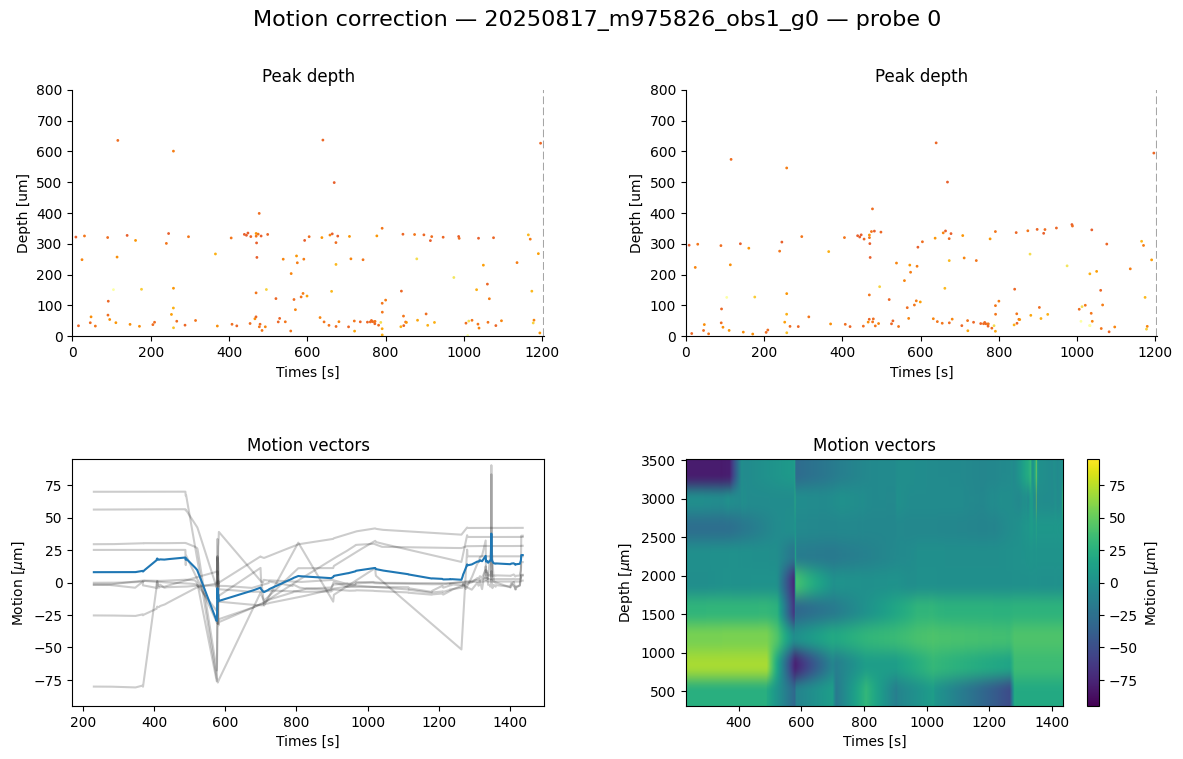

write_binary_recording (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, skipping drift correction
kilosort.run_kilosort: drift computed in 0.02s; total 0.02s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:     10.40 %     |      13.29 GB
kilosort.run_kilosort: Mem avail:    114.71 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   16.33 %     |      1.96   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.00 %     |      0.00   /    12.00 GB
kilosort.run_kilosort: Max alloc:     7.61 %     |      0.91   /    12.00 GB
kilosort.run_kilosort: ***

Skipping common average reference.
Skipping kilosort preprocessing.
Skipping drift correction.


kilosort.spikedetect: Number of universal templates: 1464
kilosort.spikedetect: Detecting spikes...
 24%|██▍       | 145/603 [02:10<07:09,  1.07it/s]

In [ ]:
preset = "dredge"
params_kilosort4 = {'do_CAR': False,
                    'skip_kilosort_preprocessing': True,
                    'do_correction': False,
                    'torch_device':'cuda',
                    'delete_recording_dat': False,
                    'n_jobs': 16}


for session in session_groups:

    session_name = str(session[0].name).split("_tcat")[0]

    print("Compute DREDge motion correction on session:", session_name)

    for it, probe in enumerate(session):

        raw_rec = si.read_spikeglx(probe.parent, 
                                   stream_name=f'imec{it}.ap', 
                                   load_sync_channel=False)

        pre_processed_rec = common_reference(bandpass_filter(recording = raw_rec,
                                                            freq_min = 300,
                                                            freq_max = 6000), 
                                            operator="median", 
                                            reference="global")


        motion, motion_info = si.compute_motion(pre_processed_rec, 
                                                preset=preset, 
                                                folder=f"{probe.parent}/DREDge_probe{it}" , 
                                                output_motion_info=True,
                                                n_jobs = 16)
        
        fig = plt.figure(figsize=(10, 5))

        si.plot_motion_info(
            motion_info, 
            pre_processed_rec,
            figure = fig,
            depth_lim=(0, 800),
            color_amplitude=True,
            amplitude_cmap="inferno",
            scatter_decimate=10,
        )

        fig.suptitle(f"Motion correction — {session_name} — probe {it}",
                     fontsize=16)
        plt.show()

        interpolated_rec = interpolate_motion(recording=pre_processed_rec.astype('float32'), 
                                              motion=motion)
        
        motion_corrected_rec = si.whiten(interpolated_rec)
        
        params_kilosort4['fs'] = interpolated_rec.get_sampling_frequency()

        sorting = si.run_sorter('kilosort4', 
                                 motion_corrected_rec, 
                                 folder=f"{probe.parent}/Kilosort4_probe{it}", 
                                 verbose=True, 
                                 **params_kilosort4)


        
        del motion, motion_info, interpolated_rec, sorting

